m=64における比較

In [1]:
# ====================================================
# Library
# ====================================================

import logging
from time import time
import pickle
from tqdm.notebook import tqdm

from numpy.random import RandomState
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition
import numpy as np
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
from scipy.stats import wishart, chi2

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/Users/mknzm/development/new_study/env_tex/01_notebook_module/bayes")

import bayes

In [3]:
# ====================================================
# Load Data
# ====================================================

rng = RandomState(0)
faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

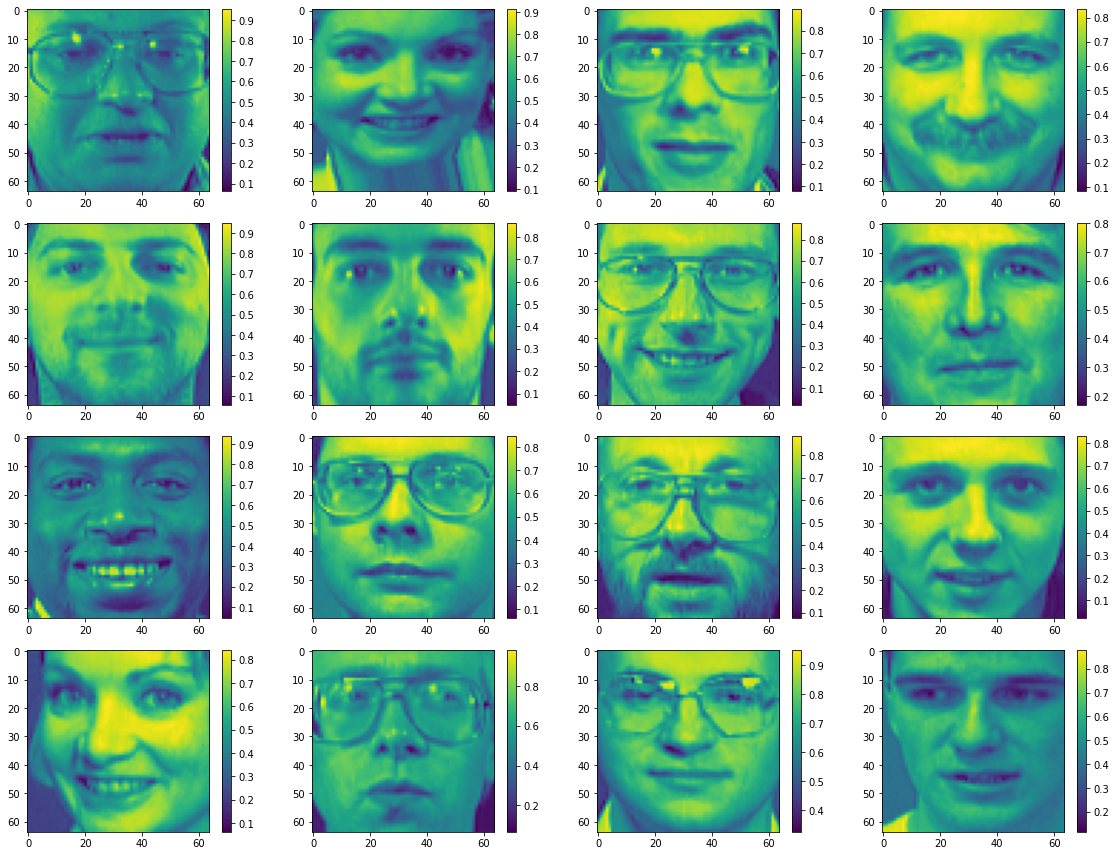

In [4]:
# ====================================================
# Show Data
# ====================================================

n_figure = 16
n_cols = 4
n_rows = 4
fig, axes = plt.subplots(figsize=(4 * n_cols, 3 * n_rows), ncols=n_cols, nrows=n_rows)
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)

for i, ax in enumerate(np.ravel(axes)):
    im = ax.imshow(faces[1+i].reshape(64,64))
    fig.colorbar(im,ax=ax)

plt.tight_layout()
plt.show()

In [5]:
if False:
    s = "y, valid, w, x, mu, sigma, w_mean, w_variance, x_mean, x_variance, mu_mean, mu_variance".split(", ")
    [print(f'"{w}":') for w in s]

In [6]:
np.random.normal(size = (10, 10)).shape

(10, 10)

In [7]:
# ====================================================
# Prepare Model
# ====================================================
np.random.seed(seed=620)

num_train = 350
train_set = faces[:num_train]
valid_set = faces[num_train:]

m = 64
d = faces.shape[1]
n = num_train

_hyp_w = np.linspace(0.5, 1.5, m)
hyp_w = wishart.rvs(100, _hyp_w)
_hyp_mu = np.linspace(0.5, 1.5, d)
hyp_mu = wishart.rvs(5000, _hyp_mu)

first_model_params = {
    "y": train_set,
    "valid": valid_set,
    "w": bayes.prior.Normal(np.zeros(shape = (m, d)), hyp_w),
    "x": bayes.prior.Normal(np.zeros(shape = (num_train, m)), np.eye(m)),
    "mu": bayes.prior.Normal(np.zeros(shape = d), hyp_mu),
    "sigma": 0.1,
    "w_mean": np.random.normal(size = (m, d)),
    "w_variance": hyp_w,
    "x_mean": np.random.normal(size = (n, m)),
    "x_variance": hyp_w,
    "mu_mean": np.random.normal(size = (d)),
    "mu_variance": hyp_mu,
}

In [8]:
print(np.linalg.norm(hyp_mu @ np.linalg.inv(hyp_mu) - np.eye(hyp_mu.shape[0])))
print(np.linalg.norm(hyp_w @ np.linalg.inv(hyp_w) - np.eye(hyp_w.shape[0])))

7.584095812736045e-13
1.2215544114090586e-14


In [9]:
LDR_first = bayes.model.LDR(**first_model_params)

In [10]:
LDR_first.optimize(10)

Epoch0: train0.1675, valid0.2165
Epoch1: train0.08959, valid0.1478
Epoch2: train0.08309, valid0.1425
Epoch3: train0.08101, valid0.1409
Epoch4: train0.08004, valid0.1401
Epoch5: train0.0795, valid0.1396
Epoch6: train0.07916, valid0.1393
Epoch7: train0.07893, valid0.1391
Epoch8: train0.07878, valid0.139
Epoch9: train0.07866, valid0.1388


In [ ]:
first_train = LDR_first.predict(faces[1:17])

n_figure = 16
n_cols = 4
n_rows = 4
fig, axes = plt.subplots(figsize=(4 * n_cols, 3 * n_rows), ncols=n_cols, nrows=n_rows)
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)

for i, ax in enumerate(np.ravel(axes)):
    im = ax.imshow(first_train[i].reshape(64,64))
    fig.colorbar(im,ax=ax)

plt.tight_layout()
plt.show()

上記は変な事前分布を使用してしまったためもっと単純なものを使用する.

In [12]:
# ====================================================
# Prepare Model
# ====================================================
np.random.seed(seed=620)

num_train = 350
train_set = faces[:num_train]
valid_set = faces[num_train:]

m = 64
d = faces.shape[1]
n = num_train

second_model_params = {
    "y": train_set,
    "valid": valid_set,
    "w": bayes.prior.Normal(np.zeros(shape = (m, d)), np.eye(m)),
    "x": bayes.prior.Normal(np.zeros(shape = (num_train, m)), np.eye(m)),
    "mu": bayes.prior.Normal(np.zeros(shape = d), np.eye(d)),
    "sigma": 0.1,
    "w_mean": np.random.normal(size = (m, d)),
    "w_variance": np.eye(m),
    "x_mean": np.random.normal(size = (n, m)),
    "x_variance": np.eye(m),
    "mu_mean": np.random.normal(size = (d)),
    "mu_variance": np.eye(d),
}

In [13]:
LDR_second = bayes.model.LDR(**second_model_params)

In [14]:
LDR_second.optimize(10)

Epoch0: train0.1636, valid0.2112
Epoch1: train0.08892, valid0.1476
Epoch2: train0.08255, valid0.1416
Epoch3: train0.08066, valid0.1396
Epoch4: train0.07981, valid0.1388
Epoch5: train0.07933, valid0.1384
Epoch6: train0.07902, valid0.1381
Epoch7: train0.0788, valid0.138
Epoch8: train0.07865, valid0.138
Epoch9: train0.07854, valid0.138


In [15]:
LDR_second.x_mean.shape

(350, 64)

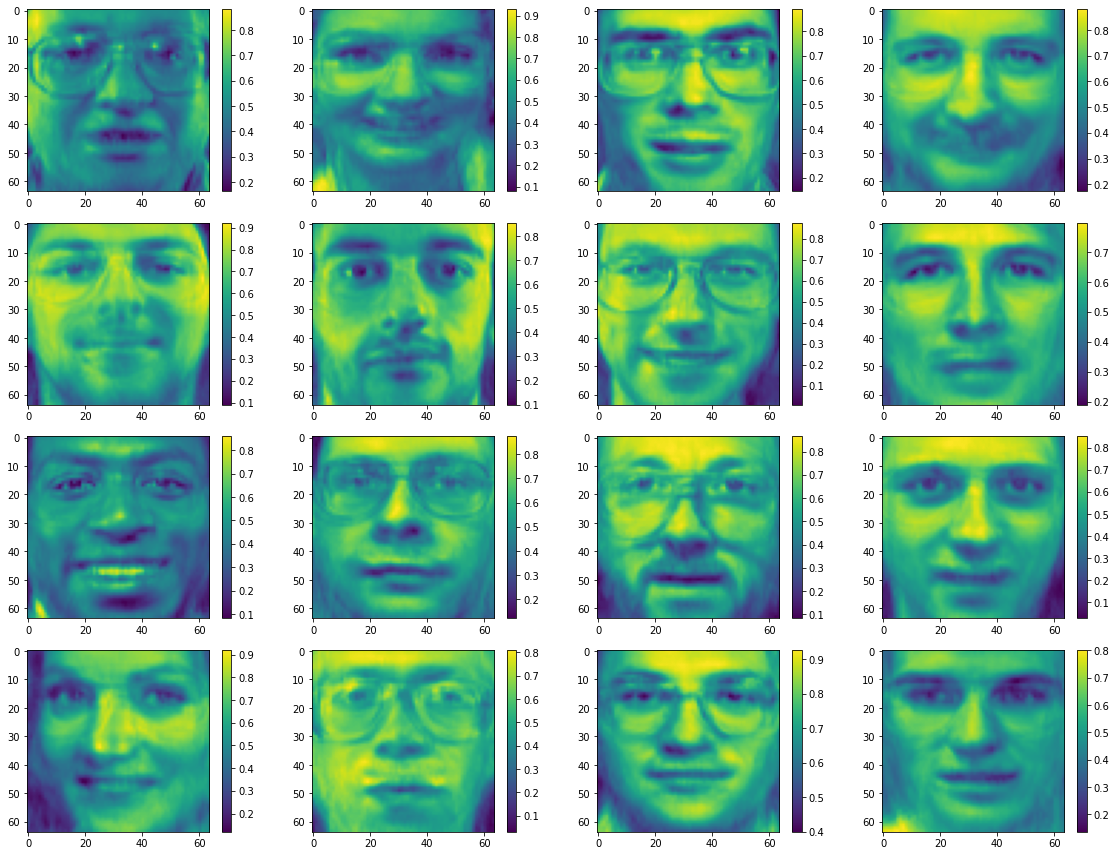

In [16]:
second_train = LDR_second.predict(faces[1:17])

n_figure = 16
n_cols = 4
n_rows = 4
fig, axes = plt.subplots(figsize=(4 * n_cols, 3 * n_rows), ncols=n_cols, nrows=n_rows)
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)

for i, ax in enumerate(np.ravel(axes)):
    im = ax.imshow(second_train[i].reshape(64,64))
    fig.colorbar(im,ax=ax)

plt.tight_layout()
plt.show()

In [17]:
# ====================================================
# Prepare Model
# ====================================================
np.random.seed(seed=620)

num_train = 350
train_set = faces[:num_train]
valid_set = faces[num_train:]

m = 64
d = faces.shape[1]
n = num_train

third_model_params = {
    "y": train_set,
    "valid": valid_set,
    "w": bayes.prior.Normal(np.zeros(shape = (m, d)), np.eye(m)),
    "x": bayes.prior.Normal(np.zeros(shape = (num_train, m)), np.eye(m)),
    "mu": bayes.prior.Normal(np.zeros(shape = d), np.eye(d)),
    "sigma": 0.1,
    "w_mean": np.random.normal(size = (m, d)),
    "w_variance": np.eye(m),
    "x_mean": np.random.normal(size = (n, m)),
    "x_variance": np.eye(m),
    "mu_mean": np.random.normal(size = (d)),
    "mu_variance": np.eye(d),
}

In [18]:
LDR_third = bayes.model.LDR(**third_model_params)

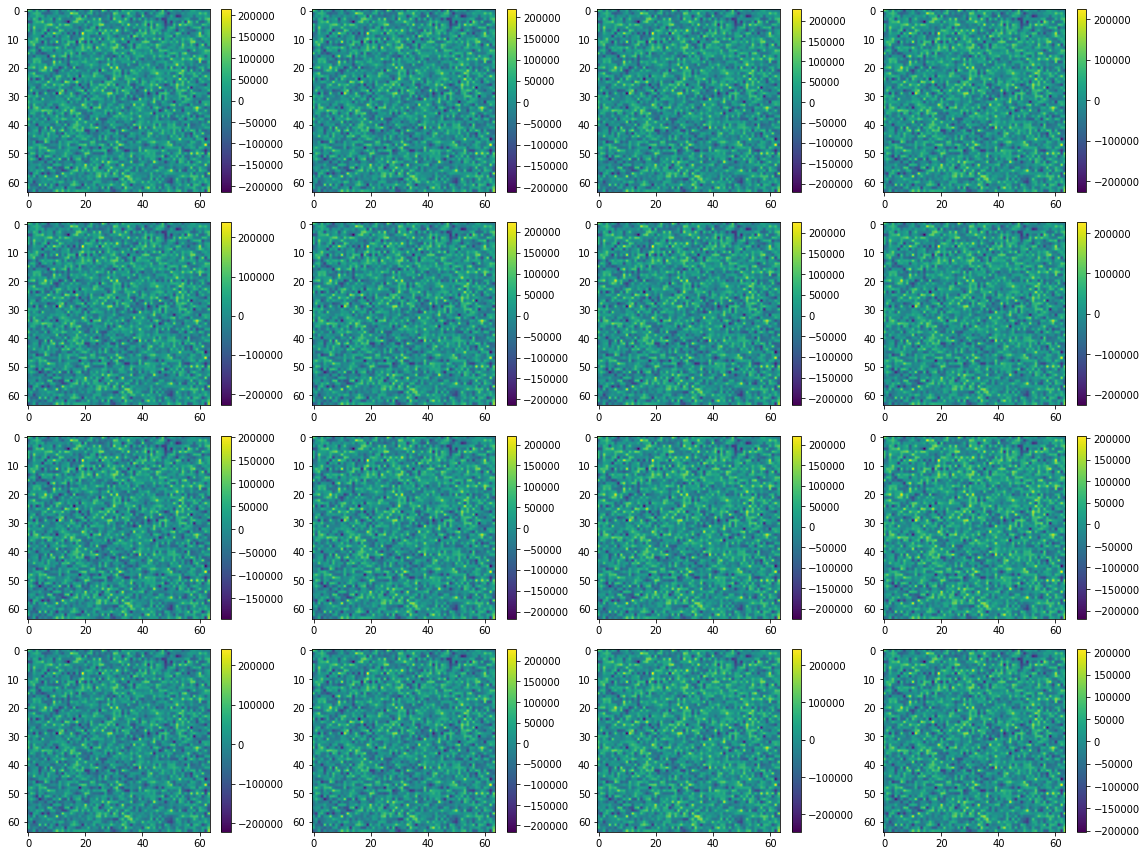

In [19]:
third_train = LDR_third.predict(faces[1:17])

n_figure = 16
n_cols = 4
n_rows = 4
fig, axes = plt.subplots(figsize=(4 * n_cols, 3 * n_rows), ncols=n_cols, nrows=n_rows)
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)

for i, ax in enumerate(np.ravel(axes)):
    im = ax.imshow(third_train[i].reshape(64,64))
    fig.colorbar(im,ax=ax)

plt.tight_layout()
plt.show()

これを見ると比較的にすぐ収束することがわかる.

今回細かくは見ないが,乱数から情報量基準を計算したりするのも今後の追加実装としてはあり.

0.13883690358795395 0.1379665352132663
0.07866147440011054 0.07853899881954789


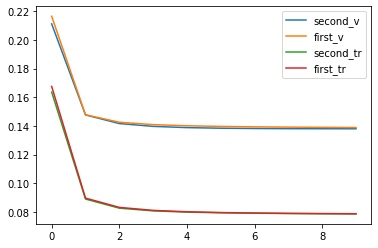

In [33]:
plt.plot(range(LDR_second.log_va.__len__()), LDR_second.log_va, label = "second_v")
plt.plot(range(LDR_first.log_va.__len__()), LDR_first.log_va, label = "first_v")

plt.plot(range(LDR_second.log_va.__len__()), LDR_second.log_tr, label = "second_tr")
plt.plot(range(LDR_first.log_va.__len__()), LDR_first.log_tr, label = "first_tr")

print(min(LDR_first.log_va), min(LDR_second.log_va))
print(min(LDR_first.log_tr), min(LDR_second.log_tr))
plt.legend(loc='upper right')

plt.show()

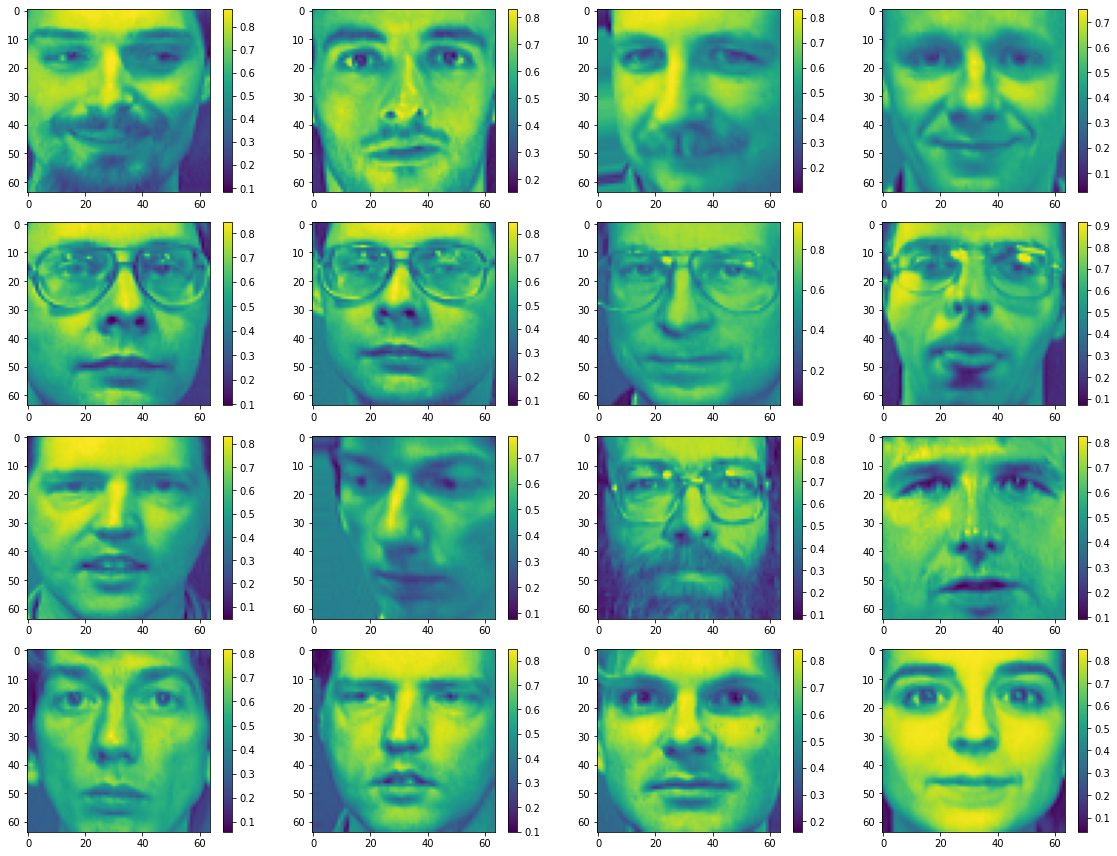

In [35]:
# ====================================================
# Show Data
# ====================================================

n_figure = 16
n_cols = 4
n_rows = 4
fig, axes = plt.subplots(figsize=(4 * n_cols, 3 * n_rows), ncols=n_cols, nrows=n_rows)
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)

for i, ax in enumerate(np.ravel(axes)):
    im = ax.imshow(valid_set[1+i].reshape(64,64))
    fig.colorbar(im,ax=ax)

plt.tight_layout()
plt.show()

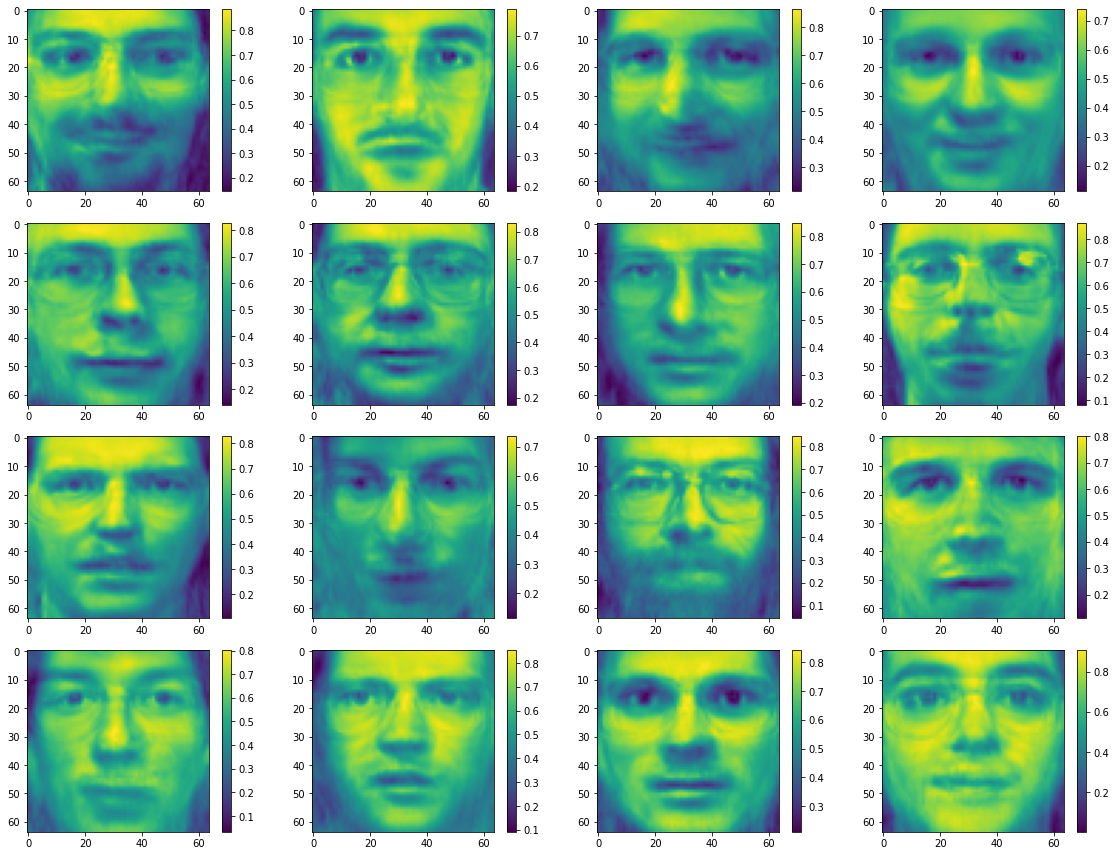

In [36]:
first_va = LDR_first.predict(valid_set[1:17])

n_figure = 16
n_cols = 4
n_rows = 4
fig, axes = plt.subplots(figsize=(4 * n_cols, 3 * n_rows), ncols=n_cols, nrows=n_rows)
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)

for i, ax in enumerate(np.ravel(axes)):
    im = ax.imshow(first_va[i].reshape(64,64))
    fig.colorbar(im,ax=ax)

plt.tight_layout()
plt.show()

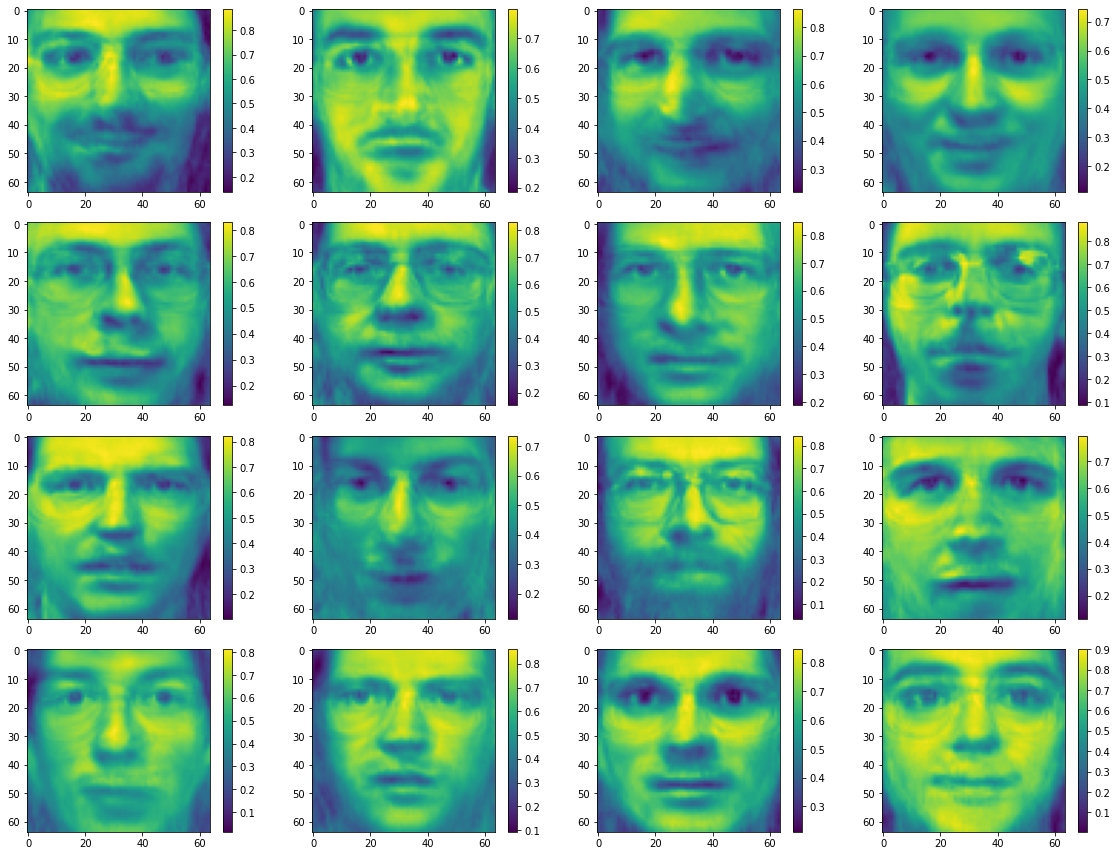

In [37]:
second_va = LDR_second.predict(valid_set[1:17])

n_figure = 16
n_cols = 4
n_rows = 4
fig, axes = plt.subplots(figsize=(4 * n_cols, 3 * n_rows), ncols=n_cols, nrows=n_rows)
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)

for i, ax in enumerate(np.ravel(axes)):
    im = ax.imshow(second_va[i].reshape(64,64))
    fig.colorbar(im,ax=ax)

plt.tight_layout()
plt.show()

In [87]:
u,s,v = np.linalg.svd(train_set)
smat = np.zeros(train_set.shape, dtype=float)
smat[:s.shape[0], :s.shape[0]] = np.diag(s)

M = m
first_x = u[:,:M]
first_w = np.dot(smat, v)[:M]
first_mu = np.mean(train_set, axis = 0)

print(first_x.shape, first_w.shape)
print(np.linalg.norm(np.dot(u, np.dot(smat, v)) - train_set))
print(np.linalg.norm((first_w.T@first_x.T).T-train_set))

(350, 64) (64, 4096)
3.726924275986129e-05
52.06151318024097


In [89]:
# ====================================================
# Prepare Model
# ====================================================
np.random.seed(seed=620)

num_train = 350
train_set = faces[:num_train]
valid_set = faces[num_train:]

m = 64
d = faces.shape[1]
n = num_train

gold_param = {
    "y": train_set,
    "valid": valid_set,
    "w": bayes.prior.Normal(np.zeros(shape = (m, d)), np.eye(m)),
    "x": bayes.prior.Normal(np.zeros(shape = (num_train, m)), np.eye(m)),
    "mu": bayes.prior.Normal(np.zeros(shape = d), np.eye(d)),
    "sigma": 0.1,
    "w_mean": first_w,
    "w_variance": np.eye(m),
    "x_mean": first_x,
    "x_variance": np.eye(m),
    "mu_mean": first_mu,
    "mu_variance": np.eye(d),
}

In [90]:
LDR_gold = bayes.model.LDR(**gold_param)

In [91]:
LDR_gold.optimize(10)

Epoch0: train0.07744, valid0.1369
Epoch1: train0.07743, valid0.1369
Epoch2: train0.07743, valid0.1369
Epoch3: train0.07743, valid0.1369
Epoch4: train0.07742, valid0.1369
Epoch5: train0.07742, valid0.1369
Epoch6: train0.07741, valid0.1369
Epoch7: train0.07741, valid0.1369
Epoch8: train0.07741, valid0.1369
Epoch9: train0.0774, valid0.1369


0.13685131707662634 0.1379665352132663
0.0774036733285309 0.07853899881954789


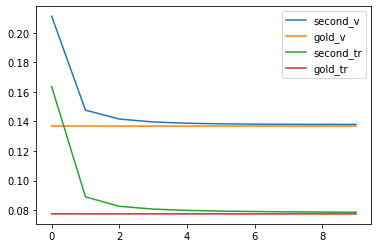

In [92]:
plt.plot(range(LDR_second.log_va.__len__()), LDR_second.log_va, label = "second_v")
plt.plot(range(LDR_gold.log_va.__len__()), LDR_gold.log_va, label = "gold_v")

plt.plot(range(LDR_second.log_va.__len__()), LDR_second.log_tr, label = "second_tr")
plt.plot(range(LDR_gold.log_va.__len__()), LDR_gold.log_tr, label = "gold_tr")

print(min(LDR_gold.log_va), min(LDR_second.log_va))
print(min(LDR_gold.log_tr), min(LDR_second.log_tr))
plt.legend(loc='upper right')

plt.show()

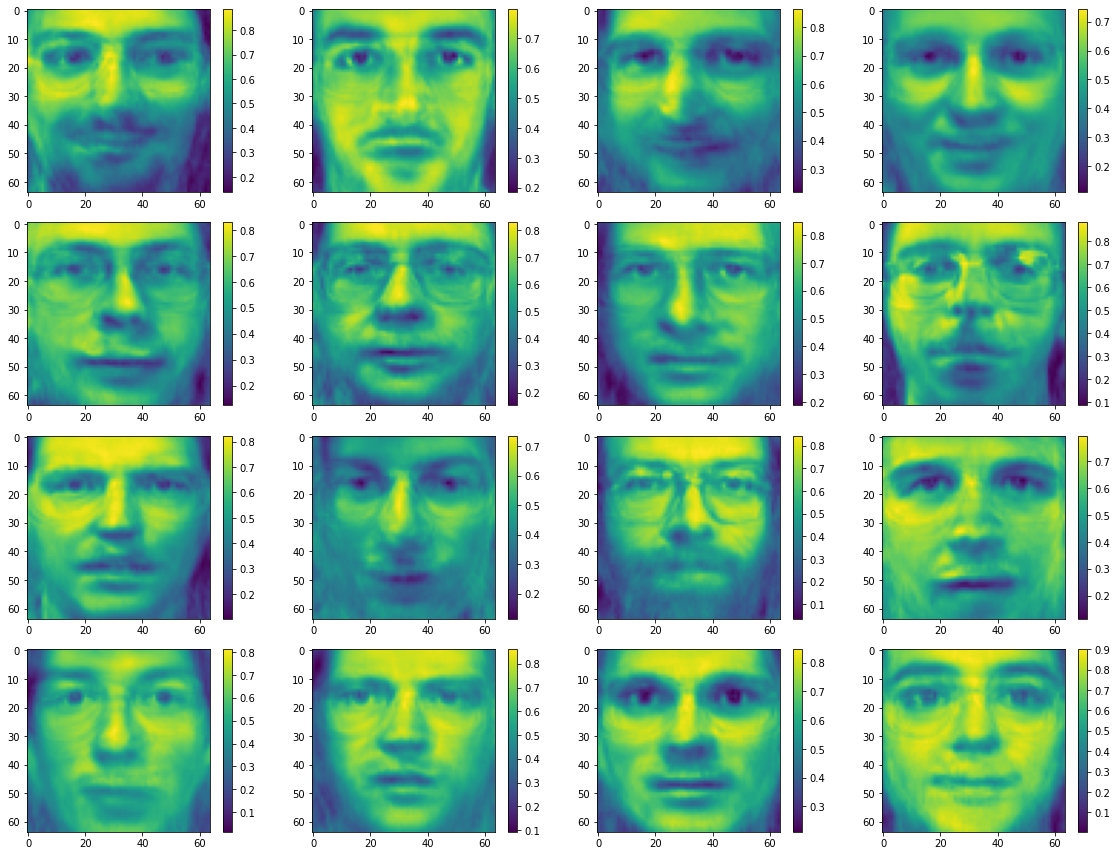

In [93]:
gold_va = LDR_gold.predict(valid_set[1:17])

n_figure = 16
n_cols = 4
n_rows = 4
fig, axes = plt.subplots(figsize=(4 * n_cols, 3 * n_rows), ncols=n_cols, nrows=n_rows)
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)

for i, ax in enumerate(np.ravel(axes)):
    im = ax.imshow(second_va[i].reshape(64,64))
    fig.colorbar(im,ax=ax)

plt.tight_layout()
plt.show()